En este notebook se va a utilizar Pytorch para poder clasificar el datase MNIST de dígitos escritos a mano. Consiste en imagenes de 28px x 28px indicando digitos escritos a mano del 0 al 9.

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Descargar el dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/home/godorluis/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset)

60000

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Cada dato del arreglo del dataset consiste en una imagen de 28x28 pixeles y su respectivo label. Podemos visualizar la imagen utilizando la libreria matplotlib.

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F5338C4C910>, 5)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Label : 5


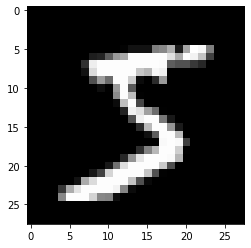

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print(f'Label : {label}')

Como se puede ver, es evidente que algunas imágenes son dificiles de reconocer incluso para el ojo humano. Si bien es útil poder ver la imagen tenemos un problema aquí. **Pytorch no sabe como trabajar con imágenes**. Necesitamos convertir las imagenes a tensores. Se puede lograr al aplicar una transformacion incluida en Pytorch al crear el dataset.

In [9]:
import torchvision.transforms as transforms

Los datasets de Pytorch nos permiten especificar una o mas funciones de transformacion que son aplicadas a las imagenes mientras son cargadas. `torchvision.transforms` contiene muchas funciones predefinidas, en este caso ocuparemos la funcion `ToTensor` para convertir las imagenes en tensores de Pytorch.

In [10]:
dataset = MNIST(
    root='data/',
    train=True,
    transform=transforms.ToTensor()
)

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


La imagen es transformada a un tensor de 1x28x28. La primera dimension es usada para mantener un registro de los canales de color. Como las imagenes del dataset MNIST estan en escala de grises hay solo un canal. Otros datasets tienen imagenes con color en cuyo caso hay 3 canales: rojo, verde y azul. Veamos aljunos ejemplos de los valores dentro del tensor.

In [12]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


Los valores van en un rango de 0 a 1 con 0 representando negro y 1 representando blanco. Los valores entremedio representan diferentes niveles de grises. Podemos plotear tambien como una imagen el tensor.

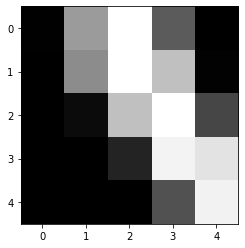

In [18]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

# Datasets de entrenamiento y validación

Mientra se crean modelos de machine learning en la práctica, es bastante común dividir el dataset en 3 partes:

1. *Set de entrenamiento*: Usado para entrenar el modulo, por ejemplo para calcular la perdida y ajustar los pesos del modelo usando el descenso de gradiente.
2. *Set de validación*: Usado para evaluar el modelo mientras se entrena, ajustar hiperparámetros (como la tasa de aprendizaje) y escoger la mejor versión del modelo.
3. *Set de testing*: Usado para comparar diferentes modelos, y reportar finalmente la precisión del modelo.

En el dataset MNIST hay 60.000 imágenes de entrenamiento y 10.000 de test. Las imágenes de test se encuentran estandarizadas para que diferentes investigadores puedan reportar sus resultados contra el mismo set de imágenes.

Como no hay un set de validación predefinido vamos manualmente a dividir el set de 60.000 imágenes en un set de entrenamiento y otro de validación. Para ello vamos a separar 10.000 imágenes de forma aleatoria. Podemos lograr esto utilizando al función `random_split` includo en Pytorch.

In [22]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

Es importante crear muestras a partir de una elección aleatoria ya que generalmente los datasets son creados de forma ordenada, de modo que las primeras imágenes corresponde a 0, luego a 1 y así sucesivamente. De modo que si escogemos el último 20% de las imágenes el set de validación correspondería a imágenes de 8 y 9s mientras que el set de entrenamiento no contendría a esas imagenes.

Ahora podemos crear data loaders para ayudarnos a cargar data in muestras. En este caso vamos a usar muestras de un tamaño de 128.

In [24]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Se usa `shuffle=True` para el dataloader del conjunto de entrenamiento de modo de que las muestras generadas en cada epoca sean diferentes, además esta randomización nos permite generalizar y acelerar el proceso de entrenamiento.

# Modelo

Ahora que hemos preparado la data podemos definir un modelo.

- Un modelo de regresión logística es casi identico a un modelo de regresión lineal, por ejemplo existen matrices de pesos y sesgo , y la salida es obtenida utilizando operaciones de matrices sencillas.
- Para esto podemos utilizar `nn.Linear` para crear nuestro modelo en vez de definir nuestras matrices de forma manual.
- Como `nn.Linear` espera que cada muestra de entrenamiento sea un vector cada imagen de  `1x28x28` debe ser transformado a un vector de tamaño 784 (28x28) antes de ser pasado al modelo.
- La salida de cada imagen es un vector de tamaño 10, con cda elementos del vector indicando la probabilidad de que una imagen pertenezca a un label entre 0 a 9. El label predecido es simplemente aquel que tenga la probabilidad más alta.

In [25]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Se crea el modelo de regresion logistica
model = nn.Linear(input_size, num_classes)

In [27]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-2.8686e-02, -3.1765e-02,  1.0496e-02,  ..., -6.9599e-03,
          5.5420e-05,  2.9746e-02],
        [ 7.2859e-03, -9.5817e-03,  2.8749e-02,  ...,  2.1367e-02,
         -3.0565e-02,  2.9453e-02],
        [ 3.5430e-02, -5.0170e-03, -3.2109e-02,  ...,  2.5602e-02,
         -1.2768e-02,  1.4677e-02],
        ...,
        [-7.2318e-03,  1.5741e-02,  3.3301e-02,  ..., -1.0405e-02,
          2.4042e-02,  2.1889e-02],
        [-5.1963e-03,  1.9359e-02,  2.3672e-02,  ..., -2.5725e-02,
         -4.3051e-03,  5.9955e-03],
        [-7.9952e-03, -7.6148e-03, -2.5388e-02,  ...,  2.0268e-02,
         -3.3370e-02, -1.0982e-02]], requires_grad=True)

In [28]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0199,  0.0316, -0.0341,  0.0176,  0.0182,  0.0015,  0.0138, -0.0043,
        -0.0320,  0.0078], requires_grad=True)

Como podemos ver el modelo en total tiene 7850 parámetros (10 * 784 + 10), no obstante nada ha cambiado respecto a lo que hicimos previamente con el modelo de regresión lineal. Vamos a intentar generar algunas salidas usando nuestro modelo. Vamos a tomar las primeras 100 imagenes de la muestra de nuestro dataset y pasarselas al modelo.

In [29]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tensor([9, 1, 2, 4, 3, 2, 8, 9, 6, 8, 0, 3, 2, 2, 4, 8, 2, 0, 1, 0, 9, 1, 1, 3,
        7, 2, 1, 5, 7, 3, 1, 2, 9, 1, 9, 1, 7, 7, 8, 8, 2, 5, 2, 7, 1, 2, 5, 7,
        5, 4, 7, 4, 3, 4, 1, 3, 6, 4, 8, 4, 6, 6, 4, 8, 8, 3, 7, 6, 9, 4, 3, 2,
        4, 4, 6, 6, 7, 6, 5, 0, 7, 4, 7, 8, 5, 5, 5, 5, 7, 6, 5, 1, 8, 7, 0, 9,
        7, 7, 5, 9, 4, 0, 6, 1, 6, 4, 9, 8, 1, 4, 7, 1, 9, 3, 2, 8, 5, 5, 3, 4,
        1, 1, 6, 6, 2, 9, 7, 7])
torch.Size([128, 1, 28, 28])


RuntimeError: size mismatch, m1: [3584 x 28], m2: [784 x 10] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41

Como podemos ver se genera un error. Esto es debido a que la data de entrada no tiene la forma apropiada. Nuestras imagenes tienen una forma de `1x28x28` pero necesitamos que sean vectores de 784. Para esto vamos a utilizar el metodo `reshape` propio del tensor, el cual nos permite de forma eficiente ver cada imagen como un vector sin cambiar nada de la data.

Para incluir esta funcionalidad adicional dentro de nuestro modelo necesitamos definir un modelo personalizado, estendiendo la clase `nn.Module` de Pytorch.

In [30]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    def forward(self, xb):
        xb = xb.reshape(-1,784)
        out = self.linear(xb)
        return out
model = MnistModel()

Dentro del constructo se inicializan los pesos y sesgos usando `nn.Linear`. Y dentro del método `forward`, el cual es invocado cuando pasamos una muestra al modelo, se transforma la entrada a un vector y se le pasa al metodo self.linear.

`xb.reshape(-1,28*28)` indica a Pytorch que queremos ver la entrada como un vector de 28x28.

Notar que el modelo ya no tiene atributos `weight` o `bias` (ya que ahora se encuentran dentro del atributo `.linear`) no obstante ahora tiene un metodo `.parameters` que retorna una lista conteniendo los pesos y sesgo, y pueden ser utilizados por el optimizador de Pytoch.

In [31]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0181, -0.0220, -0.0200,  ...,  0.0256,  0.0129,  0.0271],
         [-0.0208,  0.0285, -0.0048,  ...,  0.0341, -0.0158, -0.0238],
         [-0.0097, -0.0065,  0.0206,  ...,  0.0151,  0.0081,  0.0179],
         ...,
         [-0.0189,  0.0143,  0.0030,  ..., -0.0142,  0.0337, -0.0113],
         [ 0.0069,  0.0107, -0.0328,  ...,  0.0095,  0.0151,  0.0303],
         [-0.0349,  0.0041,  0.0010,  ...,  0.0111, -0.0066,  0.0190]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0280, -0.0306, -0.0144, -0.0250,  0.0242,  0.0208, -0.0016,  0.0142,
         -0.0214,  0.0300], requires_grad=True)]

Nuestro nuevo modelo personalizado puede ser usado exactamente igual que antes. Veamos como funciona

In [42]:
for images, labels in train_loader:
    outputs = model(images)
    break
print(f'outputs.shape : {outputs.shape}')
print(f'Sample outputs : \n {outputs[:2].data}')
print(len(outputs.data))

outputs.shape : torch.Size([128, 10])
Sample outputs : 
 tensor([[-0.5040, -0.1020,  0.1870,  0.0300, -0.1649,  0.0016, -0.1723, -0.3634,
         -0.1981, -0.4008],
        [-0.3832,  0.2775,  0.2560,  0.0249, -0.3063,  0.3165, -0.1059, -0.0885,
         -0.2439, -0.2612]])
128


Como podemos ver para cada imagen de entrada se obtiene una salida como un vector de tamaño 10, representando los 10 posibles digitos. Nos gustaría poder representar estas salidas como probabildiades, pero claramente los elementos no son probabilidades ya que podemos ver valores negativos o algunos mayores que 1.

Para convertir las salidas en probabilidades vamos a usar la funcion de activacion softmax, que posee la siguiente fórmula:

![softmax](https://i.imgur.com/EAh9jLN.png)

Primero se reemplazada cada valor `yi` en el vector de salida por `e^yi` para asegurarnos que los elementos sean positivos, luego se divide cada elemento en la suma de todos los elementos para asegurarnos que lleguen como maximo a 1.


In [34]:
import torch.nn.functional as F

La función softmax se encuentra incluida en el paquete `torch.nn.functional` y requiere que especifiquemos la dimension sobre la cual se debe aplicar la funcion.


In [43]:
probs = F.softmax(outputs, dim=1)

print(f'Probabilidades \n: {probs[:2].data}')
print(f"Suma de probabilidades : {torch.sum(probs[0]).item()}")

Probabilidades 
: tensor([[0.0701, 0.1048, 0.1399, 0.1195, 0.0984, 0.1162, 0.0977, 0.0807, 0.0952,
         0.0777],
        [0.0696, 0.1347, 0.1319, 0.1047, 0.0752, 0.1401, 0.0918, 0.0934, 0.0800,
         0.0786]])
Suma de probabilidades : 1.0


Finalmente podemos determinar el label predecido por cada imagen simplemente escogiendo el indice del elemento con la mayor probabilidad en cada output. Esto se puede lograr usando el metodo `torch.max`, el cual retorna el mayor elemento y el indice del mayor elemento sobre una dimension particular del tensor.

In [45]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([2, 5, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 1, 3, 2, 2, 9, 1, 5, 2, 5, 2, 3,
        2, 2, 2, 5, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 5, 2, 2,
        2, 2, 4, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 3, 5, 2, 2, 2, 5, 2, 2, 2, 5, 2,
        2, 2, 2, 2, 1, 2, 2, 8, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
        2, 2, 5, 5, 1, 5, 2, 2, 2, 2, 2, 2, 3, 8, 3, 2, 2, 5, 2, 1, 2, 3, 1, 2,
        2, 5, 2, 8, 2, 2, 2, 2])
tensor([0.1399, 0.1401, 0.1423, 0.1526, 0.1203, 0.1325, 0.1548, 0.1347, 0.1268,
        0.1291, 0.1285, 0.1727, 0.1833, 0.1414, 0.1335, 0.1441, 0.1374, 0.1214,
        0.1416, 0.1357, 0.1691, 0.1430, 0.1761, 0.1281, 0.1409, 0.1223, 0.1674,
        0.1454, 0.1289, 0.1485, 0.1634, 0.1296, 0.1451, 0.1354, 0.1452, 0.1518,
        0.1277, 0.1422, 0.1207, 0.1337, 0.1222, 0.1233, 0.1510, 0.1443, 0.1857,
        0.1192, 0.1535, 0.1318, 0.1328, 0.1329, 0.1242, 0.1264, 0.1345, 0.1373,
        0.1329, 0.1189, 0.1171, 0.1374, 0.1494, 0.1452, 0.1425, 0.1402, 0.1116,
       

Los numeros mostrados son los labels predecidos. Comparemoslos con los labels reales.

In [46]:
labels

tensor([2, 3, 8, 7, 1, 9, 2, 5, 1, 1, 3, 5, 8, 3, 4, 8, 1, 9, 3, 0, 8, 3, 5, 9,
        1, 1, 0, 8, 4, 5, 3, 6, 8, 7, 7, 7, 8, 9, 2, 8, 7, 4, 6, 3, 0, 1, 3, 5,
        2, 7, 1, 1, 5, 2, 5, 3, 1, 6, 9, 4, 7, 5, 1, 0, 8, 5, 6, 7, 8, 7, 0, 1,
        0, 3, 9, 2, 6, 2, 9, 0, 0, 1, 9, 6, 8, 0, 1, 3, 8, 7, 5, 6, 3, 1, 7, 1,
        0, 1, 6, 8, 5, 7, 2, 2, 0, 5, 3, 4, 4, 2, 0, 6, 3, 8, 0, 7, 8, 9, 4, 0,
        8, 0, 7, 2, 9, 8, 5, 6])

Claramente los labels predecidos y los reales son completamente diferentes. Obviamente esto es porque los pesos se han inicialiado de forma aleatoria al igual que el sesgo. Ahora necesitamos entrenar el modelo para obtener mejores predicciones.

# Metrica de evaluacion y funcion de perdida

Necesitamos una forma de valuar que tan bien esta nuestro modelo prediciendo. Una forma natural de hacer esto seria encontrar el procentaje de labels que ha predecido correctamente, es decir la presisión del modelo.

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

El operador `==` funciona como una comparasión de lementos entre dos tensores de igual forma, y retorna un nuevo tensor conteniedo 0s para los elementos no iguales y 1s para los elementos iguales. Pasarle esto al metodo `torch.sum` retorna la cantidad de labels predecidos correctamente.

In [48]:
accuracy(outputs, labels)

tensor(0.0703)

Mientras que la presisión es una buena forma para nosotros los humanos de evaluar el modelo, no puede ser usado como función de perdida para optimizar nuestro modelo por las siguientes razones.
- No es una función diferenciable. `torc.hmax` y `==` son ambas operaciones no  continuas y no diferenciables
- No toma en cuenta la probabilidad actual predicha por el modelo, asi que no puede aportar un feedback suficiente para mejorar.

Una funcion de perdida comunmente usada para problemas de clasificación es la **entropía cruzada**, la cual tiene la siguiente formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

Aún si parece complicado la verdad es bastante sencillo.

- Por cada fila de los outputs se escoge la probabilidad predicha para el label correcto.
- Luego toma el logaritmo natural de la probabilidad escogida. Si la probabilidad es alta (cercana a 1), entonces el logaritmo es un valor negativo pequeño cercano a 0. Y si la probabilidad es pequeña (cercana a 0) entonces el logaritmo es un numero negativo muy alto. Luego multiplicamos el resultado por -1 lo que nos da un valor alto de la función de perdida.



In [49]:
loss_fn = F.cross_entropy

In [50]:
loss = loss_fn(outputs,labels)
print(loss)

tensor(2.3209, grad_fn=<NllLossBackward>)


# Entrenado el modelo

Ahora que se ha definido los data_loeaders, el modelo y la funcion de perdida estamos listos para entrenar el modelo. El algoritmo de entrenamiento es identico al de regresión lineal, con la adición de una fase de validación, tal y como se ve en el siguiente pseudocodigo.

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

In [58]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generar predicciones
        loss = F.cross_entropy(out, labels) # Calcular perdida
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generar predicciones
        loss = F.cross_entropy(out, labels)   # Calcular perdida
        acc = accuracy(out, labels)           # Calcular precision
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combinar perdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combinar precision
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Ahora definiremos una funcion `evaluate` para evaluar, la cual generara la fase de validación y una funcion `fit` para generar el proceso completo de entrenamiento.

In [59]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase entrenamiento
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Fase validacion
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

La funcion`fit` guarda la funcion de perdida y la precision de cada epoca y retorna un historico del prceso de entrenamiento. Es una forma util para visualizar el proceso de entrenamiento. Antes de entrenar el modelo veamos como es la performance en el set de validaciónm con pesos y sesgos inicializados aleatorios.

In [60]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3183751106262207, 'val_acc': 0.07446598261594772}

La precision inicial es cercana al 10%, lo cual tiene sentido ya que son pesos aleatorios para una muestra de 10 posibles salidas. Probabilidad de 1 en 10 de acertar de forma aleatoria.

Ahora entrenemos el modelo por 5 epocas y veamos los resultados.

In [61]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9531, val_acc: 0.5808
Epoch [1], val_loss: 1.6826, val_acc: 0.7182
Epoch [2], val_loss: 1.4804, val_acc: 0.7612
Epoch [3], val_loss: 1.3278, val_acc: 0.7826
Epoch [4], val_loss: 1.2105, val_acc: 0.7961


En solo 5 epocas se ha obtenido una precision cercana al 80%. Ahora veamos como mejora el modelo con algunas epocas mas.

In [62]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1183, val_acc: 0.8062
Epoch [1], val_loss: 1.0444, val_acc: 0.8159
Epoch [2], val_loss: 0.9841, val_acc: 0.8215
Epoch [3], val_loss: 0.9339, val_acc: 0.8261
Epoch [4], val_loss: 0.8915, val_acc: 0.8303


In [63]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8552, val_acc: 0.8329
Epoch [1], val_loss: 0.8237, val_acc: 0.8369
Epoch [2], val_loss: 0.7963, val_acc: 0.8390
Epoch [3], val_loss: 0.7720, val_acc: 0.8419
Epoch [4], val_loss: 0.7504, val_acc: 0.8439


In [64]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7310, val_acc: 0.8459
Epoch [1], val_loss: 0.7136, val_acc: 0.8488
Epoch [2], val_loss: 0.6978, val_acc: 0.8510
Epoch [3], val_loss: 0.6833, val_acc: 0.8520
Epoch [4], val_loss: 0.6702, val_acc: 0.8532


Mientras la precision crece a medida que entrenamos el modelo, es claro que la mejoria en cada epoca es cada vez menor. Podemos verlo a traves de una grafica en matplotlib.

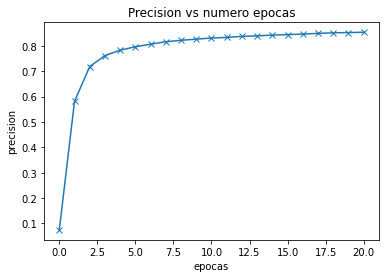

In [65]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epocas')
plt.ylabel('precision')
plt.title('Precision vs numero epocas');

# Testear el modelo con imagenes conocidas

In [66]:
test_dataset = MNIST(
    root='data/',
    train=False,
    transform=transforms.ToTensor()
)

Shape: torch.Size([1, 28, 28])
Label: 7


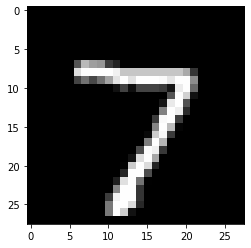

In [67]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [68]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

`img.unsqueeze` agrega otra dimension al comienzo del tensor 1x28x28, haciendolo uno de 1x1x28x28, de este modo el modelo ve la imagen como una muestra que contiene solo una iamgen.

Definimos una funcion `predict_image` que nos permite obtener el label predecido por nuestro modelo.

In [69]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


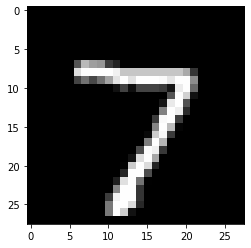

In [70]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


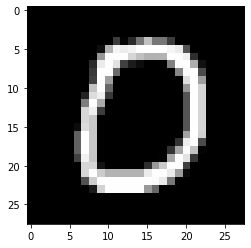

In [71]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


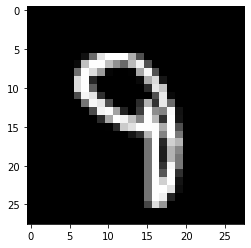

In [72]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


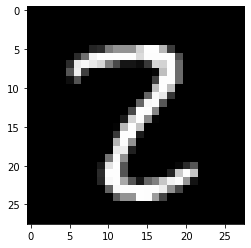

In [73]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [74]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6431774497032166, 'val_acc': 0.8594726324081421}